# [Exploration 11] 뉴스 요약봇 만들기
## 프로젝트 설명 



## 프로젝트 목표


## 01. load data
- 뉴스기사 데이터(newssummarymore.csv)사용 : [링크](https://github.com/sunnysai12345/News_Summary)

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj26/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [4]:
data.sample(10)

,headlines,text
8223,Video: Ranveer Singh turns DJ at his 2nd Mumba...,A video shows Ranveer Singh turning DJ at his ...
67906,Ryanair given deadline to give 4L flyers alter...,The UK Civil Aviation Authority (CAA) has orde...
87567,1st Star Wars film made for $11 million earned...,The first Star Wars film 'Star Wars: Episode I...
73343,Haryana Dy Advocate Gen sacked for carrying Ra...,Haryana's Deputy Advocate General Gurdass Sing...
95320,Bihar's model of Grand Alliance can defeat BJP...,Bihar Chief Minister Nitish Kumar on Monday sa...
88433,Google announces Android version for 1 GB RAM ...,Technology major Google on Wednesday announced...
51636,Mumbai Police to have 8-hour duty schedule for...,The Mumbai Police will be switching to an eigh...
70365,Hospital operation theatre's roof collapses tw...,The roof of an operation theatre of Karnataka'...
54850,School van driver held for molesting Class 8 s...,A 32-year-old school van driver was arrested o...
81308,Man who wrote book on surviving bulls trampled...,An American man who was trampled by a bull in ...


## 02. 데이터 전처리
- 중복샘플, NULL 처리

In [5]:
print('전체 data 길이 :', len(data))
print('unique한 headline 수:', data.headlines.nunique())
print('unique한 text 수:', data.text.nunique())

전체 data 길이 : 98401
unique한 headline 수: 98280
unique한 text 수: 98360


- text를 기준으로 중복데이터를 제거

In [6]:
data.drop_duplicates(subset=['text'], inplace = True)
print('전체 data 길이 :', len(data))
print('unique한 headline 수:', data.headlines.nunique())

전체 data 길이 : 98360
unique한 headline 수: 98262


- null 확인 : 없음!

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- text normalization(텍스트 정규화)
    - it'll == it will : 문법을 통일화해준다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [12]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [13]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
data.isnull().sum()

headlines    0
text         0
Text         0
Summary      0
dtype: int64

In [15]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


- 불용어, 정규화 처리 후 분포 확인
- 데이터의 길이를 정하는 단계

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 18
헤드라인의 평균 길이 : 9.553660024400163


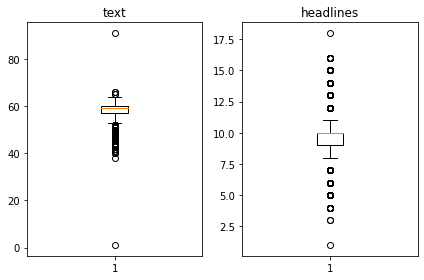

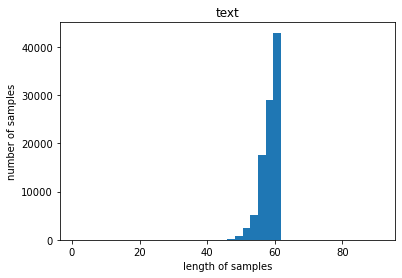

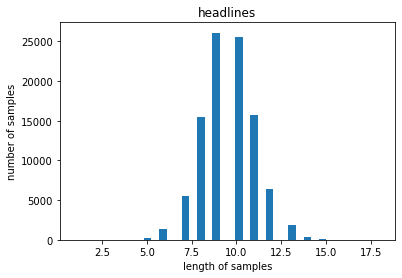

In [16]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headline_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headline_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1, 2, 1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1, 2, 2)
plt.boxplot(headline_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text의 경우 50-60 사이의 데이터가 많다. : 65 이하로 자른다. 
- headlines은 14로 잘라주도록 한다. 

In [17]:
text_max_len = 60
headline_max_len = 12

- max_len이 합리적인지 확인하기

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt/len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len, data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9768198454656364


- text에서는 0.03%, headlines에서는 2.4%정도의 데이터를 버리게 됩니다.
- 

In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플 수:', len(data))

전체 샘플 수: 95838


- 디코더에서 문장의 시작과 끝을 알 수 있도록 각 문장에 **시작토큰, 종료토큰**을 추가합니다.

In [21]:
data['decoder_input']=data['headlines'].apply(lambda x:'sostoken '+x)
data['decoder_target']=data['headlines'].apply(lambda x:x+' eostoken')
data.head()

,headlines,text,Text,Summary,decoder_input,decoder_target
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...,sostoken Delhi techie wins free food from Swig...,Delhi techie wins free food from Swiggy for on...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken New Zealand end Rohit Sharma-led Indi...,New Zealand end Rohit Sharma-led India's 12-ma...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken Aegon life iTerm insurance plan helps...,Aegon life iTerm insurance plan helps customer...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken Rahat Fateh Ali Khan denies getting n...,Rahat Fateh Ali Khan denies getting notice for...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...,weeks ex cbi director alok verma told departme...,govt directs alok verma to join work day befor...,sostoken Govt directs Alok Verma to join work ...,Govt directs Alok Verma to join work 1 day bef...


- 인코더의 입력 : data\['text'\]
- 디코더의 입력 : data\['decoder_input'\]
- 디코더의 레이블 : data\['decoder_target'\]   


- 모두 numpy타입으로 저장한다. 

In [22]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

- 데이터의 순서를 섞어줍니다.
- 정수 시퀀스 이용

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[92791 46382 78951 ... 12188  8292 21252]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

### [코드이해] np.random.shuffle 
- shuffle parameter 조건 : **xndarray or MutableSequence**
- indices가 배열의 크기보다 작을 경우엔? : index외의 데이터는 삭제된다. 
- indices가 배열의 크기보다 큰 경우엔? : 에러 발생 

In [143]:
indices = np.arange(3)
np.random.shuffle(indices)
print(indices)

[0 1 2]


In [144]:
abc = [10, 20, 30, 40, 50]
abc = np.array(abc)

In [145]:
abc = abc[indices]
abc

array([10, 20, 30])

- 전체 데이터 크기를 이용해 전체 데이터를 **훈련, 테스트**로 나눈다.

In [25]:
print('훈련 데이터의 개수:', len(encoder_input))
print('훈련 레이블의 개수:', len(decoder_input))

훈련 데이터의 개수: 95838
훈련 레이블의 개수: 95838


In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19167


- n_of_val : sklearn 함수 중 train_test_split에서 사용되는 test_size와 같은 역할

In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 76671
훈련 레이블의 개수 : 76671
테스트 데이터의 개수 : 19167
테스트 레이블의 개수 : 19167


In [32]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

Step 1. 데이터 수집하기

Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.

Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

# 정리     
---        
1. 이미지 로드
2. DeepLab 모델 생성
3. pretrained weight 불러오기
4. 피사체 sementic segmentation
5. 배경 blur처리
6. 피사체, 배경 합성 

# 루브릭 평가
---
1. **Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.**   
    - 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.


2. **텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.**  
    - 모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다. 
    
     
3. **Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.** 
    - 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다.
   

    
# 회고
---
## 어려웠던 점 
- 모델에 대한 이해
    - 이미 학습된 가중치를 불러오기 때문에 그 구조에 대해서 자세하게 알기 힘들어 따로 여러 자료들을 찾아보았다.
- 사진을 촬영하는 방법
    - 참고 글을 계속해서 읽어보아도 제대로 이해되지는 않았다.
    
## 알게된 점 
- 스티커 사진 프로젝트([Exp.3](https://github.com/miinkang/Project_AIFFEL/blob/main/%5BE-03%5Dcamera_sticker_application.ipynb))를 할 때 사용했던, 여러 이미지(벡터)연산들을 다시 사용해보면서 개념을 확실하게 이해했다.
- openCV의 여러 함수들도 다시 학습할 수 있었다.
    
## 더 공부할 점
- 사진
    - 실제 카메라의 작동법에 더 알아두면 이미지 처리하는 데에 많은 인사이트를 얻을 수 있을 것이라고 생각한다.
    
## 시도한 것들
- openCV의 여러 함수들의 파라미터들을 변경해보면서 쓰임새를 익혔다.

## 다짐
- 모델이 왜 연구되었는지에 대한 배경을 아는 것이 확실히 모델의 구조를 이해하기 쉽게한다.